In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os, sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA

In [4]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras import Model
from tensorflow.keras import layers

In [5]:
import e_nose.data_visualization as dv

In [6]:
import os
from pathlib import Path
import numpy as np
from e_nose import file_reader
from e_nose import data_processing as dp

from e_nose.measurements import DataType

In [8]:
import classification.data_loading as dl

In [7]:
os.getcwd()

'/Users/valentinstarlinger/Documents/Uni/RCI/3_Semester/Roboy/catkin_ws/src/roboy_smells/notebooks'

In [10]:
measurements = dl.get_measurements_from_dir('../data')
ms_train, ms_val = dl.train_test_split(measurements, 0.7)

Reading file ../data/data_apple_juice_coffee_powder_red_Wine_wodka_orange_juice_raisin_8_loops_for_5.0_min_referenceTime_30.0_min_2020-2-18_7_14.csv
using sensor 5 specification
Reading file ../data/data_isopropanol_raisin_apple_juice_wodka_coffee_powder_red_Wine_2_loops_for_5.0_min_referenceTime_30.0_min_2020-2-15_13_24.csv
using sensor 5 specification
Reading file ../data/data_coffee_powder_orange_juice_isopropanol_raisin_red_Wine_wodka_10_loops_for_5.0_min_referenceTime_30.0_min_2020-2-28_7_57.csv
using sensor 5 specification
Reading file ../data/data_apple_juice_coffee_powder_red_Wine_wodka_orange_juice_raisin_3_loops_for_5.0_min_referenceTime_30.0_min_2020-2-19_8_8.csv
using sensor 5 specification
Reading file ../data/data_isopropanol_raisin_apple_juice_wodka_coffee_powder_red_Wine_5_loops_for_5.0_min_referenceTime_30.0_min_2020-2-15_23_37.csv
using sensor 5 specification
Reading file ../data/data_apple_juice_coffee_powder_red_Wine_wodka_orange_juice_raisin_8_loops_for_5.0_min_ref

In [13]:
def create_labels_with_data(meas):
    #create sets for visualisation
    labels_with_data = {}
    for ms in meas:
        if ms.label not in labels_with_data:
            labels_with_data[ms.label] = np.expand_dims(ms.get_data()[:64], axis=0)
        else:
            labels_with_data[ms.label] = np.vstack((labels_with_data[ms.label], np.expand_dims(ms.get_data()[:64], axis=0)))
    return labels_with_data


In [14]:
lwd_train = create_labels_with_data(ms_train)

In [15]:
lwd_val = create_labels_with_data(ms_val)

In [16]:
class RecurrentLayer(layers.Layer):
    def __init__(self, dilation_rate=1, filter_size=64):
        super(RecurrentLayer, self).__init__()
        self.sigm_out = Conv1D(filter_size, 2, dilation_rate=2**dilation_rate, padding='causal', activation='sigmoid')
        self.tanh_out = Conv1D(filter_size, 2, dilation_rate=2**dilation_rate, padding='causal', activation='tanh')
        self.same_out = Conv1D(filter_size,1,padding='same')

    def call(self, x):
        original_x = x

        x_t = self.tanh_out(x)
        x_s = self.sigm_out(x)

        x = layers.Multiply()([x_t,x_s])
        x = self.same_out(x)
        x_skips = x
        x = layers.Add()([original_x, x])

        return x_skips, x
            
class Model1DCNN(tf.keras.Model):
    def __init__(self, dilations=3, filter_size=64, input_shape=(64, 49)):
        super(Model1DCNN, self).__init__()

        self.residual = []
        self.dilations = dilations
        self.causal = tf.keras.layers.Conv1D(filter_size, 2, padding='causal', input_shape=input_shape)

        for i in range(1, dilations + 1):
            self.residual.append(RecurrentLayer(dilation_rate=i, filter_size=filter_size))

        self.same_out_1 = tf.keras.layers.Conv1D(filter_size, 1, padding='same', activation='relu')
        self.same_out_2 = tf.keras.layers.Conv1D(8, 1, padding='same', activation='relu')

        self.d1 = tf.keras.layers.Dense(400, activation='relu')
        self.d2 = tf.keras.layers.Dense(200, activation='relu')
        self.d3 = tf.keras.layers.Dense(20)

    def call(self, x):
        x_skips = []

        x = self.causal(x)
        for i in range(self.dilations):
            x_skip, x = self.residual[i](x)
            x_skips.append(x_skip)

        x = tf.keras.layers.Add()(x_skips)
        x = self.same_out_1(x)
        x = self.same_out_2(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [17]:
batch_size = 90

In [18]:
def triplet_loss(self, feats):
        m = 0.01

        diff_pos= feats[0:batch_size:3] - feats[1:batch_size:3]
        diff_pos_sq = tf.math.reduce_sum(diff_pos**2, axis=1)
        diff_neg= feats[0:batch_size:3] - feats[2:batch_size:3]
        diff_neg_sq = tf.math.reduce_sum(diff_neg**2, axis=1)

        L_triplet = tf.math.reduce_sum(tf.math.maximum(0.0, 1 - diff_neg_sq/(diff_pos_sq + m)))

        L_pair = tf.math.reduce_sum(diff_pos_sq)
        return L_triplet + L_pair

In [26]:
model = Model1DCNN()
model.compile(optimizer='adam',loss=triplet_loss)
model.train_on_batch(lwd_train['apple_juice'][:1], lwd_train['apple_juice'][:1])
model.load_weights('/Users/valentinstarlinger/ray_results/cnn_wavenet_roboy/CNNTrainable_202f38b6_0_filter_size=64,lr=0.00044002,num_dilations=3_2020-03-02_20-15-06oirbobht/checkpoint_20/model_weights')

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [28]:
all_the_data_array = np.zeros((0,20))
for i, label in enumerate(lwd_train.keys()):
    prediction = model.predict(lwd_train[label])
    all_the_data_array = np.vstack((all_the_data_array, prediction))
    
for i, label in enumerate(lwd_val.keys()):
    prediction = model.predict(lwd_val[label])
    all_the_data_array = np.vstack((all_the_data_array, prediction))
    
print(all_the_data_array.shape)

(142, 20)


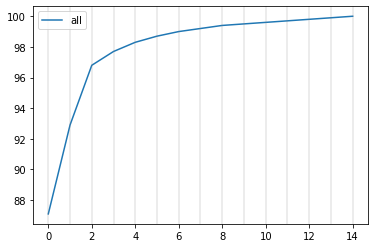

In [29]:
pca = PCA(15)
pca.fit_transform(all_the_data_array)

explained_variance = pca.explained_variance_ratio_

var=np.cumsum(np.round(explained_variance, decimals=3)*100)
plt.plot(var, label='all')
for i in range(15):
    plt.axvline(x=i, alpha=0.2, color="grey")

plt.legend()
plt.show()

wodka xkcd:red
coffee_powder xkcd:blue
isopropanol xkcd:green
orange_juice xkcd:orange
raisin xkcd:grey
red_Wine xkcd:black
apple_juice xkcd:purple


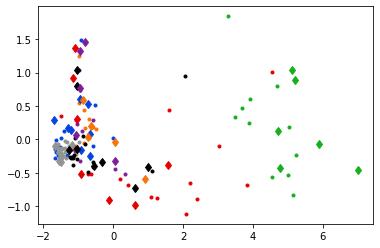

In [30]:
colors = ['xkcd:red','xkcd:blue','xkcd:green','xkcd:orange','xkcd:grey','xkcd:black','xkcd:purple']

for i, label in enumerate(lwd_train.keys()):
    prediction = model.predict(lwd_train[label])
    print(label,colors[i])
    for pred in prediction:
        pred = pca.transform(pred.reshape(1, -1))
        plt.plot(pred[0][0], pred[0][1], '.', label=label, color=colors[i])
        
for i, label in enumerate(lwd_train.keys()):
    if label not in lwd_val:
        continue
    prediction = model.predict(lwd_val[label])
    for pred in prediction:
        pred = pca.transform(pred.reshape(1, -1))
        plt.plot(pred[0][0], pred[0][1], 'd', label=label, color=colors[i])
plt.show()